# Problem 2

(b) Consider a spin chain consisting of $N$ spin-$\frac{1}{2}$ particles, where each spin can point either in the positive or negative $z$-direction. Additionally, an external magnetic field is applied to the system.

This quantum system is described by the Transverse Ising Hamiltonian. For a closed spin chain with a transverse magnetic field of intensity $h$, the Hamiltonian is:

$$
H = - \sum_{i=1}^{N} Z_i \otimes Z_{i+1} - h \sum_{i=1}^{N} X_i,
$$

where $Z_i$ and $X_i$ are the Pauli-Z and Pauli-X operators acting on the $i$-th spin site, respectively. In a closed chain, the site $N+1$ is identified with the first site.

You must implement a variational quantum algorithm in Pennylane that, for a given value of the transverse magnetic field $h$, computes the ground state energy of the spin chain with $N = 4$ sites. The magnetic field intensity $h$ should be passed as an input to the algorithm.

## Solution:

As always, we install and import the libraries needed:


In [1]:
#Library installation
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.2 MB/s eta 0:00:00


In [90]:
#Import necesary libraries
import pennylane as qml
from pennylane import numpy as pnp
import random

Now we will define the hamiltonian for a given number of qubits and $h$ intensity value

In [91]:
import numpy as np

#We will define the construction of the hamiltonian for a 
#cyclic Ising Transverse model 
def Ising_T_hamiltonian(h, n_qubits=4):
    """
    A function to compute the hamiltonian for a spin chain with n_qubits sites and periodical boundaries.
    Input:
     -) h: The traverse magnetic field intensity
     -) n_qubits: number of sites in the lattice
    Output:
     -) H: The hamiltonioan of the spin chain.
    """

    #First term of the hamiltonian -(Z_{i} (x) Z_{i+1}) for i \in {0,...,n_qubits}
    #Here the mod operator on the 2nd Z gate is to satisfy the condition that Z_{N + 1} = Z_{1}
    ops = [-1 * (qml.PauliZ(i) @ qml.PauliZ((i+1) % (n_qubits))) for i in range(n_qubits)]

    #Second term of the hamiltonian -h*(X_i) for i \in {0,...,n_qubits}
    ops +=[-h*qml.PauliX(i) for i in range(n_qubits)]

    # Creating the hamiltonian
    H = pnp.sum(ops)
    return H


The second step here is to Apply the Ansatz:

(With a lot of try and error and) Motivated by the idea that adjacents points in the Ising spin chain interacts
with each other, we can induce this interaction via CNOT gates arranged in a cyclical way. 

An heuristic argument of this is that in order to implement non-local interactions it is necesary to implement it via non-local gates. The Reason to utilize CX gates and not another one, like the CZ gate it wsa merely by try and error.

In [92]:
def parametrized_ansatz_circuit(theta_vec= None, num_layers = 3, num_qubits= 4):

  if theta_vec is None:
    tot_num_parameters = (2 * num_qubits * (num_layers + 1) )

    #we will select random rotation between the -pi to pi interval
    theta_vec = pnp.random.uniform(low= -pnp.pi, high= pnp.pi, size= tot_num_parameters)
     
  #first application of rotation gates. the rotation angle
  # will be the variational parameter to optimized.
  #this is encoded in the theta input

  for d in range(num_layers):
    for wire in range(num_qubits):
      
  

      ry_rot_angle = theta_vec[(d * num_qubits + wire)*2 ]
      rz_rot_angle = theta_vec[(d * num_qubits + wire)*2 + 1]

      qml.RY(phi= ry_rot_angle, wires= wire)
      qml.RZ(phi= rz_rot_angle, wires= wire)
    
    #Once the rotating angles are applied, embeed
    #the non local gates to the qubits in a cyclical arrangement
    for i in range(num_qubits):
        qml.CNOT(wires=[i, (i+1) % num_qubits])


  #and the end of the algorithm, we apply a last layer of rotating
  #gates in order to perform fine tuning to the final quantum state
  for wire in range(num_qubits):
      
      
      ry_rot_angle = theta_vec[(num_layers * num_qubits + wire) * 2]
      rz_rot_angle = theta_vec[(num_layers * num_qubits + wire) * 2+1]

      qml.RY(phi= ry_rot_angle, wires= wire)
      qml.RZ(phi= rz_rot_angle, wires= wire)
  
  pass




Once the ansatz and the hamiltonian is defined, we now to define our cost function to minimize 
and then apply the VQE routine for it:

In [93]:
NUM_QUBITS= 4

dev = qml.device("lightning.qubit", wires= NUM_QUBITS)

@qml.qnode(dev)
def Energy_parametrized_cost_function(theta_vec = None , num_qubits= NUM_QUBITS, num_layers= 3, Op= None):

    #first, we generate the initial parameter vector which it will be random
    #in order be as partial as possible at the Hilbert Space search space.

    #the total number of needed parameters can be obtained with a 
    #a simple counting argument of parameters.
    tot_num_parameters = (2 * num_qubits * (num_layers + 1))

    #we will select random rotation between the -pi to pi interval
    theta = pnp.random.uniform(low= -pnp.pi, high= pnp.pi, size= tot_num_parameters)

    #and apply the ansatz to the circuit
    parametrized_ansatz_circuit(theta_vec= theta_vec, num_layers= num_layers, num_qubits= num_qubits)

    # and return the exp value of an arbitrary operator
    if not Op:
        Op = qml.Identity(num_qubits)


    return qml.expval(Op)


Now, we define a gradient descent optimizar to solve the minimization problem.

(<Figure size 2300x500 with 1 Axes>, <Axes: >)

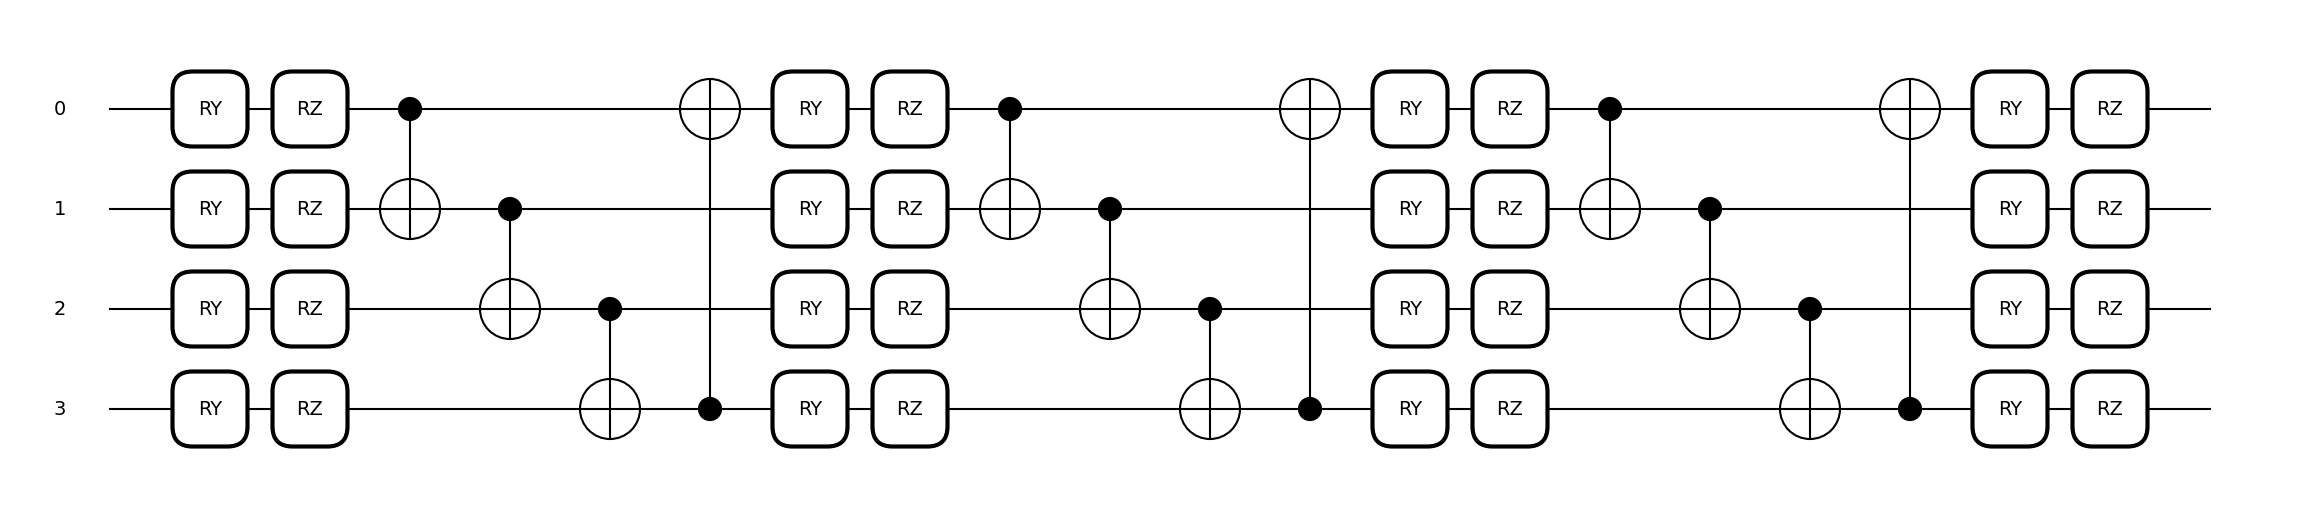

In [94]:
#Draw circuit
qml.draw_mpl(parametrized_ansatz_circuit)()

Finally, we will implement the Optimization routine, completing in this way the 
VQE algorithm!

In [115]:
def VQE_ISING_MIN_ENERGY(h= 1, num_qubits= 4, num_layers= 3):

    #first we generate the hamiltonian:
    Ising_Hamiltonian = Ising_T_hamiltonian(h= h, n_qubits= 4)

    #then, we apply the anstaz and measure the expected value of 
    #the Hamiltonian in our quantum computer/simulator

    #first, it is needed to generate the initial anstaz.

    #the total number of needed parameters can be obtained with a 
    #a simple counting argument of parameters.
    tot_num_parameters = (2 * num_qubits * (num_layers + 1))

    #Then, generate a random initial point, where the entries are going to be
    #random rotation between the (-pi, pi) interval

    theta = pnp.random.uniform(low= -pnp.pi, high= pnp.pi, size= tot_num_parameters, requires_grad= True)

    theta = pnp.random.random(size= tot_num_parameters, requires_grad= True) * (2 * pnp.pi) #random


    

    #then, we apply the anstaz and measure the expected value of 
    #the Hamiltonian in our quantum computer/simulator
    Energy_parametrized_cost_function(theta_vec= theta, num_qubits= num_qubits,
                                      num_layers= num_layers, Op= Ising_Hamiltonian)

    #now we define our optimizer and do the optimization:
    opt = qml.GradientDescentOptimizer(stepsize= 0.2)


    #Define parameters for the optimization process
    delta_E = 10 # See energy changes
    tol = 1e-6 # tolerance of the algorithm
    results = [] #Store the results,

    # run the VQE optimization loop until convergence threshold is reached
    while abs(delta_E) > tol:

        #run the optimizer once and store the parameters and Energy expectation value
        
        # Ejecutar el optimizador y obtener los nuevos parámetros y el costo anterior
        data, prev_energy = opt.step_and_cost(Energy_parametrized_cost_function, 
                                               theta, num_qubits, num_layers, Ising_Hamiltonian)

        theta = data[0]
        # Calcular la nueva energía


        new_energy = Energy_parametrized_cost_function(theta, num_qubits, num_layers, Ising_Hamiltonian)
        
        #compute the new energy
        delta_E= new_energy - prev_energy # Compare new energy value with the previous one
        results.append(new_energy) #Store the new energy

        if len(results) % 20 == 0:
            print(f"Step = {len(results)},  Energy = {new_energy:.6f}") #Print the energy value every 20 iterations
    
    print(f"state took {len(results)} iterations until convergence.")

    return results[-1]


Once all is ready to run, now we will compute our Ground State energy with VQE for any set of parameters:

In [116]:
#Parameters of the system, feel free to change it if you want!
H_INTENSITY = 1
NUM_QUBITS = 4
NUM_LAYERS = 3

VQE_gs_energy =  VQE_ISING_MIN_ENERGY(h= H_INTENSITY, num_qubits= NUM_QUBITS,
                                      num_layers= NUM_LAYERS)

print(f'\n Ground State energy found with VQE: {VQE_gs_energy}')


Step = 20,  Energy = -4.934012
Step = 40,  Energy = -5.184335
Step = 60,  Energy = -5.217751
Step = 80,  Energy = -5.223405
Step = 100,  Energy = -5.224641
Step = 120,  Energy = -5.225015
Step = 140,  Energy = -5.225203
Step = 160,  Energy = -5.225336
Step = 180,  Energy = -5.225438
Step = 200,  Energy = -5.225520
Step = 220,  Energy = -5.225587
Step = 240,  Energy = -5.225643
Step = 260,  Energy = -5.225688
Step = 280,  Energy = -5.225727
Step = 300,  Energy = -5.225759
Step = 320,  Energy = -5.225787
Step = 340,  Energy = -5.225810
state took 355 iterations until convergence.

 Ground State energy found with VQE: -5.225826167313284


For this system in particular, it is feasable to compare this result with the analytical solution. By utilizing the matrix representation 
of the Hamiltonian, which is a matrix $M \in \mathbb{M}_{16 \times 16}$, is possible to diagonalize it and compare the results:

In [106]:

#Analytical solution:
import numpy as np
from scipy.linalg import expm

# Define Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])

# Define tensor product for 4 qubits
def tensor_product(operators):
    result = np.eye(1)
    for op in operators:
        result = np.kron(result, op)
    return result

# Create the Hamiltonian for N=4
def hamiltonian(N, h):
    H = np.zeros((2**N, 2**N))
    for i in range(N):
        # Interaction term Z_i Z_{i+1}
        ZiZi_next = tensor_product([Z if j == i or j == (i + 1) % N else I for j in range(N)])
        H -= ZiZi_next
    
    # Transverse field term
    for i in range(N):
        Xi = tensor_product([X if j == i else I for j in range(N)])
        H -= h * Xi
        
    return H

# Parameters
N = 4
h = 1.0  # Example value for h

# Construct the Hamiltonian and diagonalize it
H = hamiltonian(N, h)
eigenvalues, eigenvectors = np.linalg.eigh(H)

# The ground energy and ground state
ground_energy = eigenvalues[0]
ground_state = eigenvectors[:, 0]

rel_err = pnp.abs((ground_energy - VQE_gs_energy) / ground_energy) * 100

print(f'Analitc Ground energy: {ground_energy:.6f}')
print(f'Relative Error between VQE vs Analitic: {rel_err:.6f} %')



Analitc Ground energy: -5.226252
Relative Error between VQE vs Analitic: 0.015943 %


As we can see, for the case with h = 1, there is a precision of approximately 0.016 % with respect of the analytical solution!
Proving that our Anstaz was able to found the minimum energy!

### Further research: Phase Transitions in this model

It is well known in the literature that, depending on the value of h, the system is paramagnetic if $h < 1$ and ferromagnetic if $h \geq 1$, where at the value of h = 1 a phase transition of the kind of the material is carried on. We will see how this occurs by computing the minimum energy for diferent values of the $h$ parameter:

In [ ]:
%%capture 

#this magic command is to not show any output :D

#We generate diferent values of h
h_values = pnp.arange(start= 0, stop= 2.5, step= 0.1)

#we generate where we are going to save the data
vqe_energies = pnp.zeros_like(h_values)
exact_energies = pnp.zeros_like(h_values)

#we compute the different energy for a varying magnetic field
for i, h in enumerate(h_values):
    #vqe energy
    vqe_e = VQE_ISING_MIN_ENERGY(h= h, num_qubits= 4, num_layers= 3)

    #exact energy
    H = hamiltonian(4, h)
    eigval, eigvec = pnp.linalg.eigh(H)
    exact_e = eigval[0]

    #we save the data:
    vqe_energies[i] = vqe_e
    exact_energies[i] = exact_e

#This may will take a while but it is worth it!
#If it is taking a lot, feel free to change the h_values in which we are sweeping!


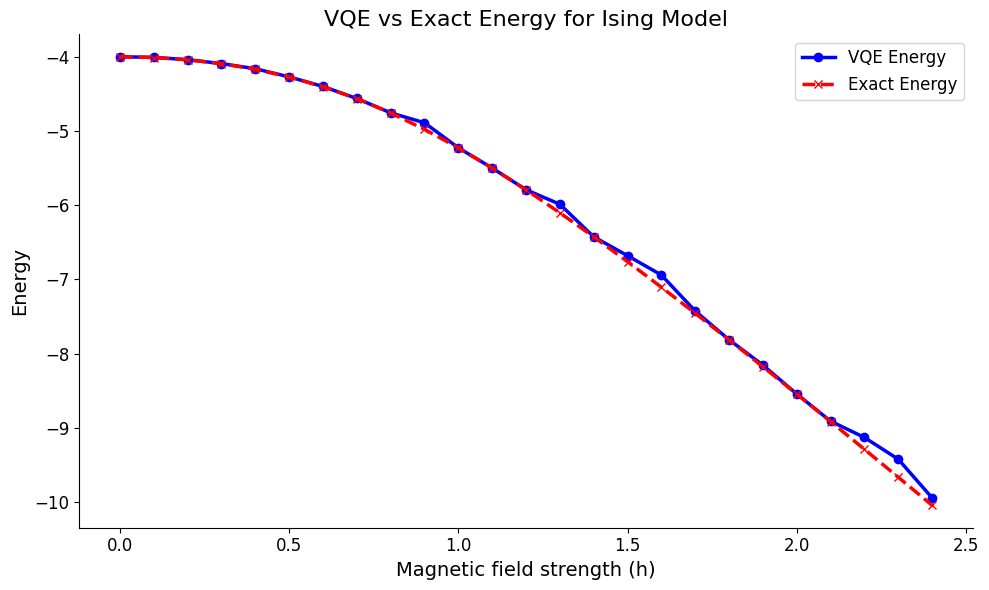

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que ya tienes tus datos en `h_values`, `vqe_energies`, y `exact_energies`

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar las energías de VQE y las exactas
ax.plot(h_values, vqe_energies, label='VQE Energy', color='blue', linewidth=2.5, marker='o')
ax.plot(h_values, exact_energies, label='Exact Energy', color='red', linewidth=2.5, linestyle='--', marker='x')

# Añadir etiquetas y título
ax.set_xlabel('Magnetic field strength (h)', fontsize=14)
ax.set_ylabel('Energy', fontsize=14)
ax.set_title('VQE vs Exact Energy for Ising Model', fontsize=16)
ax.grid(True)

# Añadir la leyenda
ax.legend(fontsize=12)

# Mejorar el estilo de los ejes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

# Mostrar el gráfico
plt.tight_layout()

As we can see, as the intensity of the external field increases, the ground state energy also does it! just as our courses in statistical mechanics!